In [1]:
import pynq
import time
from pynq import PL
import xrfclk
import xrfdc
import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.daccomb as daccomb
import mkidgen3
import mkidgen3.util
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.ifboard import IFBoard
import logging
from logging import getLogger
import json

In [2]:
logging.basicConfig()
logging.getLogger('mkidgen3').setLevel('INFO')

In [6]:
ol = g3.configure('OPFB_Test/iqtest.bit', clocks=True,
                  external_10mhz=True, ignore_version=True)
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/jupyter_notebooks/OPFB_Test/iqtest.bit
PL Timestamp: 2022/3/9 20:8:41 +133346
Overlay timestamp: 2022/3/9 20:8:41 +133346  Loaded: True


In [4]:
%pwd

'/home/xilinx/jupyter_notebooks'

## Setup DAC REPLAY

In [107]:
tones = np.array([0.1e9])
amplitudes = np.array([0.75])

In [108]:
dactable = g3.set_waveform(tones, amplitudes, fpgen=lambda x: (x*2**15).astype(np.uint16))
qtones = dactable['frequencies']
qphases = dactable['phases']
iqtable = dactable['iq']

## ADC Capture

In [116]:
adc_cap_result=ol.capture.capture_adc(2**15)
adc_capture_data = adc_cap_result[:,0] + 1j*adc_cap_result[:,1]
adc_capture_data/=2**15
del adc_cap_result

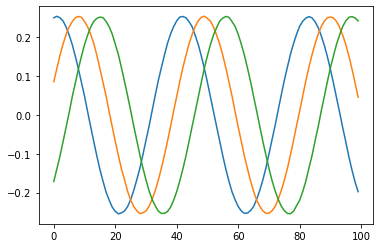

In [117]:
plt.plot(adc_capture_data.real[:100])
plt.plot(adc_capture_data.real[2000:2100])
plt.plot(adc_capture_data.real[4000:4100])

## Plot ADC Out

In [118]:
N = adc_capture_data.size
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)
time = np.linspace(0,Tc,N) # Time vector (seconds)

### Time Series

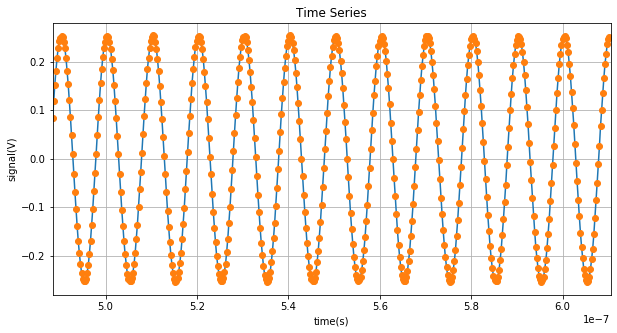

In [115]:
timeseries_plot_start=2000
timeseries_plot_stop= 2500
timeseries_sl = slice(timeseries_plot_start,timeseries_plot_stop)

plt.figure(figsize=(10,5))
# plt.plot(time[sl],(ps_buf&0xffff)[sl].astype(np.int16), '-', label='real')
plt.plot(time[timeseries_sl],adc_capture_data.real[timeseries_sl])
plt.plot(time[timeseries_sl],adc_capture_data.real[timeseries_sl],"o")
plt.grid(True)
plt.xlabel("time(s)",position=(0.5,1))
plt.ylabel("signal(V)",position=(0,0.5))
ax = plt.gca()
ax.set_xlim(time[timeseries_plot_start],time[timeseries_plot_stop])
#plt.legend()
plt.title('Time Series')
plt.show()

### FFT

In [122]:
fft_start = 0
fft_stop = adc_capture_data.size
fft_sl = slice(fft_start, fft_stop)
fft_freqs = np.linspace(-2.048e9,2.048e9,fft_stop-fft_start)
y_fft = 20*np.log10(np.abs(fftshift(fft(adc_capture_data[fft_sl]))))         # Calculate the FFT, and also shift so that f=0Hz is in the center.

In [123]:
def plot_fft(f, y, log=False, xlim=(-2.048e9,2.048e9), ylim=None):
    plt.plot(fft_freqs[::2],y_fft[::2] - max(y_fft)) # Plot every other
    plt.grid(True)
    ax = plt.gca()
    if log:
        plt.yscale("log")
    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.xlabel("Frequency[Hz]", position=(0.5,0.5))
    plt.ylabel("power", position=(1,0.5))
    plt.title('FFT')

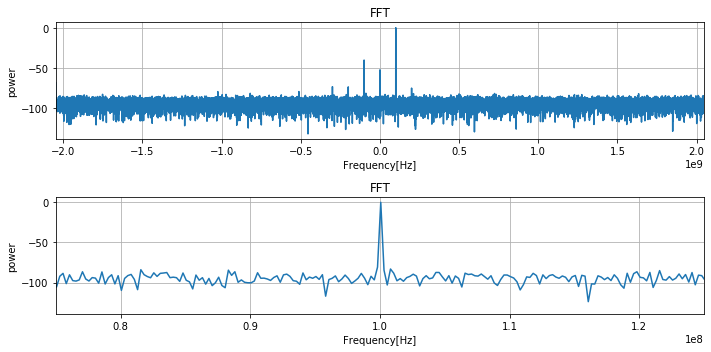

In [124]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft))
plt.subplot(212)
plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft), xlim=(75e6,125e6))
plt.tight_layout()

## Resonator selection

In [ ]:
g3.set_channels(tones)
ol.photon_pipe.reschan.bin_to_res.bins

#### Or manually

In [6]:
bins = np.zeros(2048, dtype=int)
bins[:32]=2147
bins[-8:]=2147
#bins[:tones.size] = g3.drivers.bintores.opfb_bin_number(tones)+2048
ol.photon_pipe.reschan.bin_to_res.bins=bins

## DDC Configuration

In [ ]:
g3.set_tones(tones)
ol.photon_pipe.reschan.resonator_ddc.tones

#### Or manually

In [ ]:
ddctones = np.zeros((2, 2048))
ddctones[0, :tones.size] = g3.drivers.ddc.tone_increments(tones)
ddctones[1, :tones.size] = 0  #Phase offsets to 0
ol.photon_pipe.reschan.resonator_ddc.tones = ddctones

## Check for rolling capture

In [70]:
bins = np.zeros(2048, dtype=int)
bins[:10]=2147
bins[511]=2147
bins[1022-5:1025+5]=2147
ol.photon_pipe.reschan.bin_to_res.bins=bins

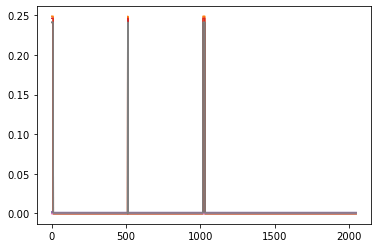

In [72]:
x=[]
for i in range(4):
    b=ol.capture.capture_iq(500, groups='all', tap_location='rawiq', prepare=False)
    x.append(b.copy())
    del b
    plt.plot(x[-1].mean(0)/2**15)


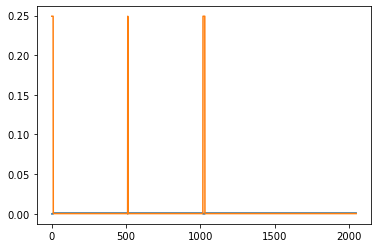

In [13]:
plt.plot(x[-1].mean(0)/2**15)

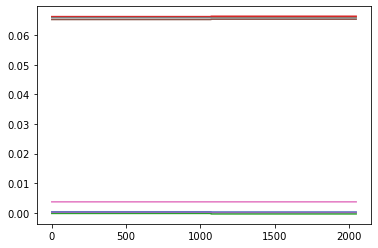

In [69]:
for i in range(4):
    b=ol.capture.capture_iq(256, groups='all', tap_location='rawiq', prepare=False)
    x=b.copy()
    del b
    plt.plot(x.mean(0)/2**15)

In [86]:
bins = np.zeros(2048, dtype=int)
bins[:]=x=2149
bins[-8:]=x
#bins[:tones.size] = g3.drivers.bintores.opfb_bin_number(tones)+2048
ol.photon_pipe.reschan.bin_to_res.bins=bins

In [91]:
b=ol.capture.capture_iq(256, groups='all', tap_location='rawiq')

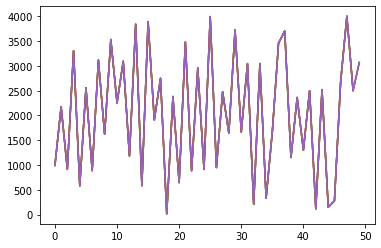

In [92]:
plt.plot(b[1:50,[0,1071],1])
plt.plot(b[:50,[1072,-1,-7],1])

In [93]:
ol.capture.axis2mm.len=64*2
ol.capture.axis2mm.start()
ol.capture.axis2mm.cmd_ctrl_reg

{'r_busy': True,
 'r_err': False,
 'r_complete': False,
 'r_continuous': False,
 'r_increment_n': False,
 'r_tlast_syncd_n': False,
 'decode_error': False,
 'slave_error': False,
 'overflow_error': False,
 'aborting': False,
 'fifo_len': 9,
 'abort': 0}

In [90]:
ol.capture.axis2mm.abort()

In [78]:
ol.capture.axis2mm.cmd_ctrl_reg

{'r_busy': False,
 'r_err': False,
 'r_complete': False,
 'r_continuous': False,
 'r_increment_n': False,
 'r_tlast_syncd_n': False,
 'decode_error': False,
 'slave_error': False,
 'overflow_error': False,
 'aborting': False,
 'fifo_len': 9,
 'abort': 0}

## OPFB Capture

In [14]:
bins = np.zeros(2048, dtype=int)
bins[:10] = [0,2047,2048,2049,4095,2147,2148,2149,1000,3000]
bins[-100:]=2147
bins[1000:1023]=2147
ol.photon_pipe.reschan.bin_to_res.bins=bins

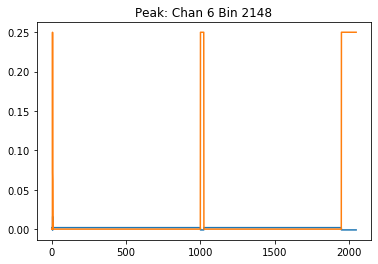

In [15]:
b=ol.capture.capture_iq(1000, groups='all', tap_location='rawiq', prepare=False)
x=b.copy()
del b

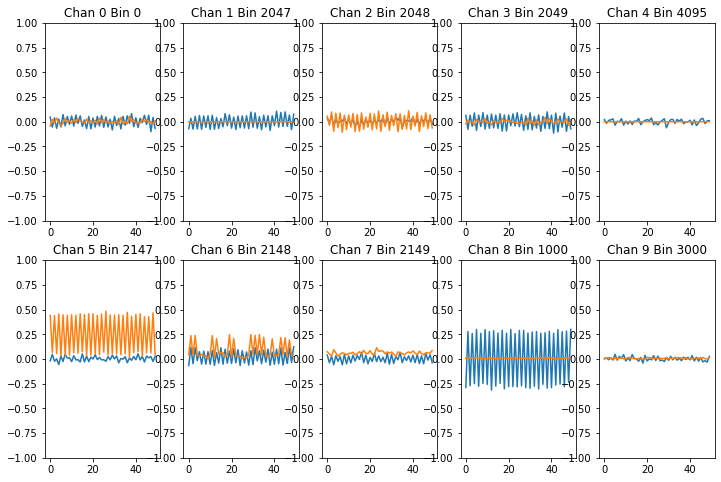

<Figure size 432x288 with 0 Axes>

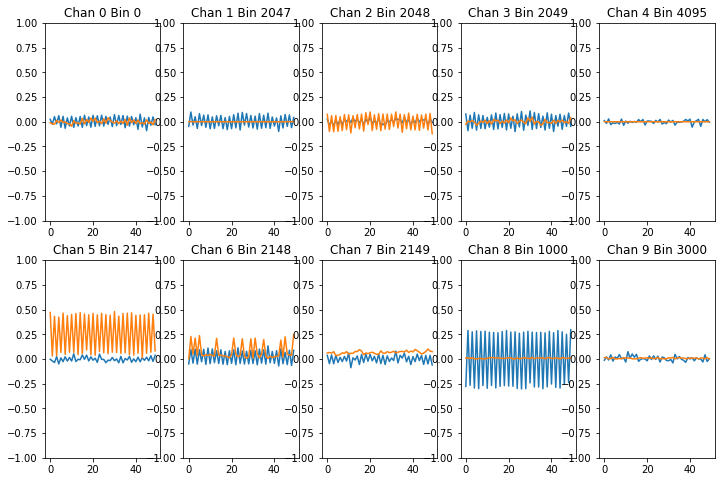

In [40]:
b=ol.capture.capture_iq(256, groups='all', tap_location='rawiq', prepare=False)
x=b.copy()
del b
fig,axes=plt.subplots(2,5,figsize=(12,8))
for i,ax in zip(range(10),axes.flat):
    plt.sca(ax)
    plt.plot(x[:50,i]/2**15)
    plt.title(f'Chan {i} Bin {bins[i]}')
    plt.ylim(-1,1)
plt.figure()
b=ol.capture.capture_iq(256, groups='all', tap_location='rawiq', prepare=False)
x=b.copy()
del b
fig,axes=plt.subplots(2,5,figsize=(12,8))
for i,ax in zip(range(10),axes.flat):
    plt.sca(ax)
    plt.plot(x[:50,i]/2**15)
    plt.title(f'Chan {i} Bin {bins[i]}')
    plt.ylim(-1,1)

In [27]:
def capture_opfb(n=256):
    out = np.zeros((n, 4096), dtype=np.complex64)
    ol.photon_pipe.reschan.bins=range(0, 4096,2)
    x = ol.capture.capture_iq(n, 'all',tap_location='rawiq', prepare=False)
    out[:,::2].real = x[...,0]/2**15
    out[:,::2].imag = x[...,1]/2**15
    x.freebuffer()

    ol.photon_pipe.reschan.bins=range(1, 4096,2)
    y = ol.capture.capture_iq(n, 'all',tap_location='rawiq', prepare=False)
    out[:, 1::2].real = y[...,0]/2**15
    out[:, 1::2].imag = y[...,1]/2**15
    y.freebuffer()
    return out

Check which capture locations are supported:

In [28]:
opfb_out = capture_opfb(256)

In [25]:
opfb_bin_fft = np.fft.fft(opfb_out,axis=0)

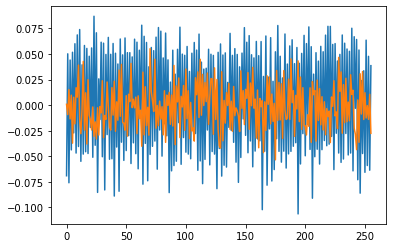

In [37]:
b=2048
plt.plot(opfb_out[:,b].real)
plt.plot(opfb_out[:,b].imag)

In [23]:
opfb_out.shape

(256, 4096)

In [ ]:
sio.savemat('300MHz_OPFB_out_test1.mat', mdict={'opfb_out_test_1':opfb_out})

In [ ]:
def gen_bin_cen(bin):
    return bin-2047

In [ ]:
gen_bin_cen(4095)

In [ ]:
bin_center = -2047

plt.plot(np.linspace(-2047-1,-2047+1,a_fft.shape[0]), np.fft.fftshift(20*np.log10(np.abs(a_fft[:,3000]))))
plt.plot(np.linspace(-2046-1,-2046+1,a_fft.shape[0]), np.fft.fftshift(20*np.log10(np.abs(a_fft[:,3001]))))


def plot_opfb_bins(data_in, bins, overlap=True):
    def gen_bin_freqs:
        return linspace()

In [ ]:
opfb_cap_result = ol.capture.capture_iq(8192, groups='all', tap_location='iq', duration=False) #rawiq=bin2res #iq=lowpassed  #ddciq=before lowpass (unsupported)

In [ ]:
opfb_cap_result.shape

In [ ]:
opfb_capture_data = opfb_cap_result[:,:,0]/2**15 + 1j*opfb_cap_result[:,:,1]/2**15

In [ ]:
opfb_cap_result.freebuffer()

In [ ]:
opfb_capture_data.shape

## Phase Capture

In [ ]:
phase = ol.capture.capture_phase(8192, groups='all', duration=False)

In [ ]:
phase.shape

In [ ]:
plt.plot(phase[:,0]/2**13)
plt.plot(phase[:,1]/2**13)
plt.plot(phase[:,2]/2**13)
plt.plot(phase[:,3]/2**13)

## Manual phase capture

In [ ]:
n=100
groups = [0,1,2,3,4]  #0-127
self=ol.capture

In [ ]:
self.switch.set_driver(slave=self.SOURCE_MAP['phase'], commit=True)

In [ ]:
print(self.axis2mm.cmd_ctrl_reg)
self.axis2mm.abort()
self.axis2mm.clear_error()
if not self.axis2mm.ready:
    print("capture core unable not ready, this shouldn't happen")
print(self.axis2mm.cmd_ctrl_reg)

In [ ]:
self.filter_phase.keep = groups
n_groups = self.filter_phase.n_kept

In [ ]:
# each group is 16 phases (32 bytes)
capture_bytes = n * 2 * n_groups*16

try:
    buffer = allocate((n, n_groups*16), dtype='i2', target=self.ddr4_0)
except RuntimeError:
    getLogger(__name__).warning(f'Insufficient space for requested samples.')
    raise RuntimeError('Insufficient free space')
addr = buffer.device_address

datavolume_mb = capture_bytes / 1024 ** 2
datarate_mbps = 32 * 512/4 * n_groups/128   #phases arrive 4@512 so the filter outputs every 4 clocks
captime = datavolume_mb / datarate_mbps

msg = (f"Capturing ~{datavolume_mb:.2f} MB of data @ {datarate_mbps:.1f} MBps. "
       f"ETA {datavolume_mb / datarate_mbps * 1000:.0f} ms")
print(msg)

In [ ]:
self.axis2mm.addr = buffer
self.axis2mm.len = n
self.axis2mm.start(continuous=False, increment=True)
self._capture('phase', capture_bytes, addr)
time.sleep(captime)

### Scratchpad